In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
import numpy as np
import os

In [15]:
# Define una función para cargar y preprocesar las imágenes y máscaras
def load_and_preprocess_frame(image_path, mask_path):
    image = tf.image.decode_png(tf.io.read_file(image_path), channels=1)  # Lee la imagen en escala de grises
    mask = tf.image.decode_png(tf.io.read_file(mask_path), channels=1)    # Lee la máscara en escala de grises
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0      # Normaliza la imagen
    mask = tf.image.convert_image_dtype(mask, tf.float32) / 255.0        # Normaliza la máscara
    return image, mask

<h2>Rutas a las carpetas de entrenamiento y prueba para imágenes y máscaras

In [16]:
train_frame_dir = 'EchoNet-Dynamic/Frames/TRAIN'
train_mask_dir = 'EchoNet-Dynamic/Mask/TRAIN'

test_frame_dir = 'EchoNet-Dynamic/Frames/TEST'
test_mask_dir = 'EchoNet-Dynamic/Mask/TEST'

val_frame_dir = 'EchoNet-Dynamic/Frames/VAL'
val_mask_dir = 'EchoNet-Dynamic/Mask/VAL'

<h2>Pre-Procesamiento de los datos

In [64]:
# Carga y preprocesa los datos de entrenamiento, validación y prueba
train_frame_files = [os.path.join(train_frame_dir, filename) for filename in os.listdir(train_frame_dir)]
train_mask_files = [os.path.join(train_mask_dir, filename) for filename in os.listdir(train_mask_dir)]

train_dataset = tf.data.Dataset.from_tensor_slices((train_frame_files, train_mask_files))
train_dataset = train_dataset.map(load_and_preprocess_frame)

# Carga y preprocesa los datos de validación
val_frame_files = [os.path.join(val_frame_dir, filename) for filename in os.listdir(val_frame_dir)]
val_mask_files = [os.path.join(val_mask_dir, filename) for filename in os.listdir(val_mask_dir)]

val_dataset = tf.data.Dataset.from_tensor_slices((val_frame_files, val_mask_files))
val_dataset = val_dataset.map(load_and_preprocess_frame)

# Carga y preprocesa los datos de prueba
test_frame_files = [os.path.join(test_frame_dir, filename) for filename in os.listdir(test_frame_dir)]
test_mask_files = [os.path.join(test_mask_dir, filename) for filename in os.listdir(test_mask_dir)]

test_dataset = tf.data.Dataset.from_tensor_slices((test_frame_files, test_mask_files))
test_dataset = test_dataset.map(load_and_preprocess_frame)

<h2>Define la arquitectura del modelo U-Net

In [65]:
# Definición de la arquitectura U-Net
def unet_model0(input_shape=(128, 128, 1)):
    inputs = Input(shape=input_shape)
    
    # Codificación (downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Capa de menor resolución
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decodificación (upsampling)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    # Capa de salida
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)  # Un solo canal de salida para la segmentación binaria
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [66]:
def unet_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Codificación
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decodificación
    up2 = keras.layers.UpSampling2D(size=(2, 2))(pool1)
    up2 = keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up2)
    merge2 = keras.layers.concatenate([conv1, up2], axis=3)
    conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)

    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv2)
    model = keras.models.Model(inputs, outputs)
    return model

In [70]:
def unet_complex(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    
    # Codificación
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Capa central
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decodificación
    up3 = keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up3 = keras.layers.Conv2D(256, 2, activation='relu', padding='same')(up3)
    merge3 = keras.layers.concatenate([conv3, up3], axis=3)
    conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(merge3)
    conv5 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up2 = keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up2 = keras.layers.Conv2D(128, 2, activation='relu', padding='same')(up2)
    merge2 = keras.layers.concatenate([conv2, up2], axis=3)
    conv6 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv6 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up1 = keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up1 = keras.layers.Conv2D(64, 2, activation='relu', padding='same')(up1)
    merge1 = keras.layers.concatenate([conv1, up1], axis=3)
    conv7 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv7 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(conv7)
    model = keras.models.Model(inputs, outputs)
    return model

In [75]:
# Crea y compila el modelo
input_shape = (112, 112, 1)
model = unet_complex(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

<h2>Entrenamiento del modelo

In [77]:
EPOCHS = 5
BATCH = 32

model.fit(train_dataset.batch(BATCH), epochs=EPOCHS, validation_data=val_dataset.batch(BATCH))

Epoch 1/5


467/467 [==============================] - 218s 466ms/step - loss: 0.0078 - accuracy: 0.8868 - val_loss: 0.0030 - val_accuracy: 0.8866
Epoch 2/5
467/467 [==============================] - 224s 481ms/step - loss: 0.0029 - accuracy: 0.8868 - val_loss: 0.0030 - val_accuracy: 0.8866
Epoch 3/5
467/467 [==============================] - 225s 482ms/step - loss: 0.0029 - accuracy: 0.8868 - val_loss: 0.0027 - val_accuracy: 0.8866
Epoch 4/5
467/467 [==============================] - 227s 486ms/step - loss: 0.0027 - accuracy: 0.8868 - val_loss: 0.0027 - val_accuracy: 0.8866
Epoch 5/5
467/467 [==============================] - 226s 485ms/step - loss: 0.0027 - accuracy: 0.8868 - val_loss: 0.0027 - val_accuracy: 0.8866


<h2>Predicciones

In [78]:
# Realiza predicciones en datos de prueba
test_images, test_masks = zip(*test_dataset)
test_images = tf.stack(test_images)
predictions = model.predict(test_images)

80/80 [==============================] - 14s 176ms/step


In [79]:
import matplotlib.pyplot as plt
def visualize_segmentation(images, masks, predictions):
    num_samples = len(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 6))

        # Imagen original
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Imagen Original')

        # Máscara de segmentación real
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Máscara Real')

        # Máscara de segmentación predicha
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Máscara Predicha')

        plt.tight_layout()
        plt.show()

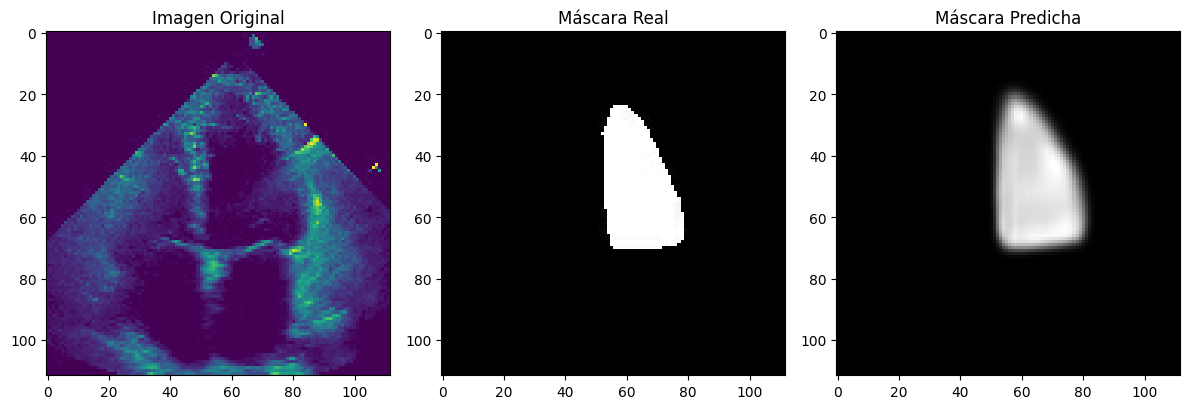

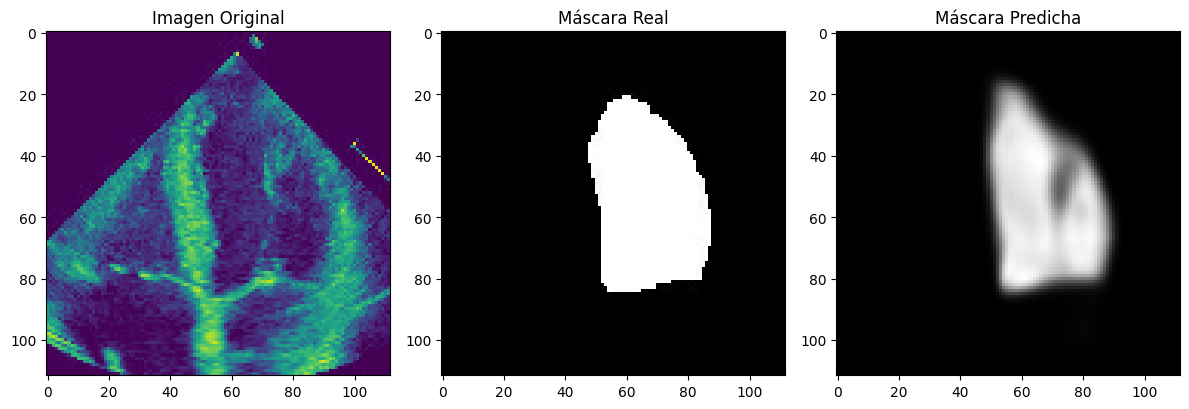

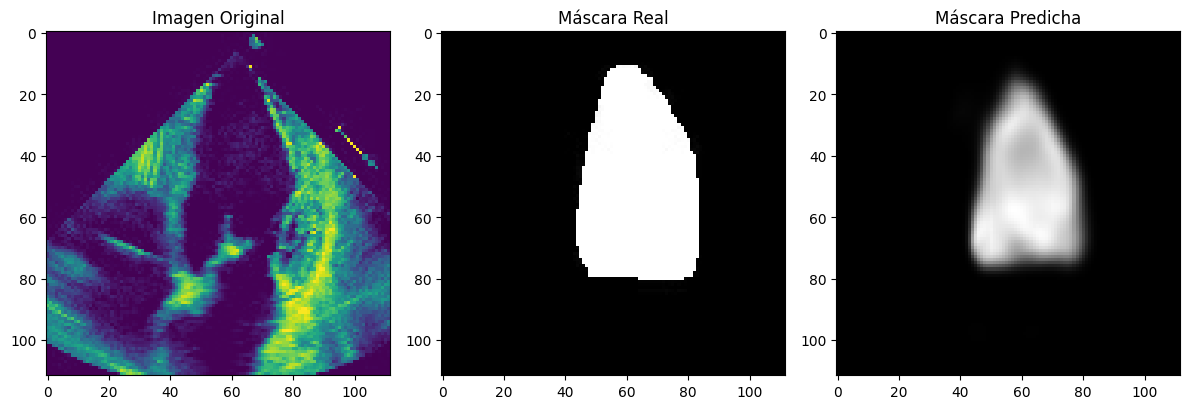

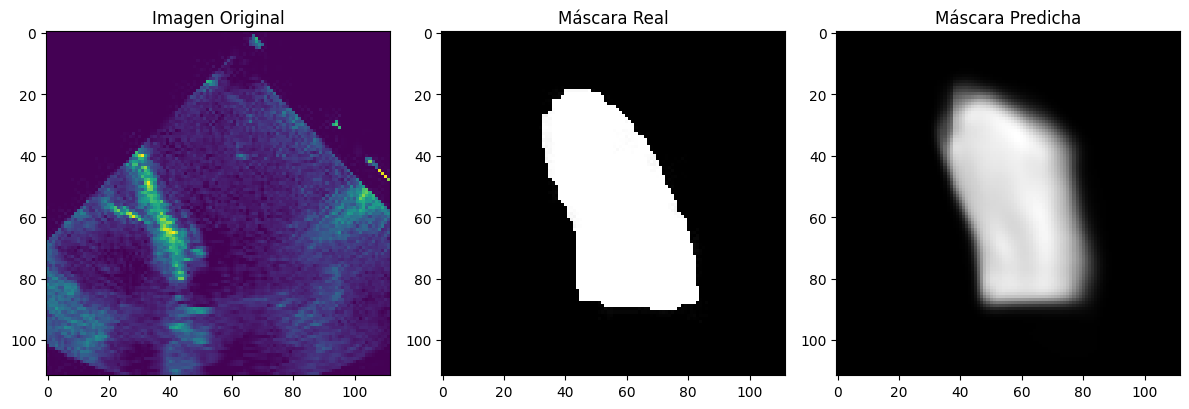

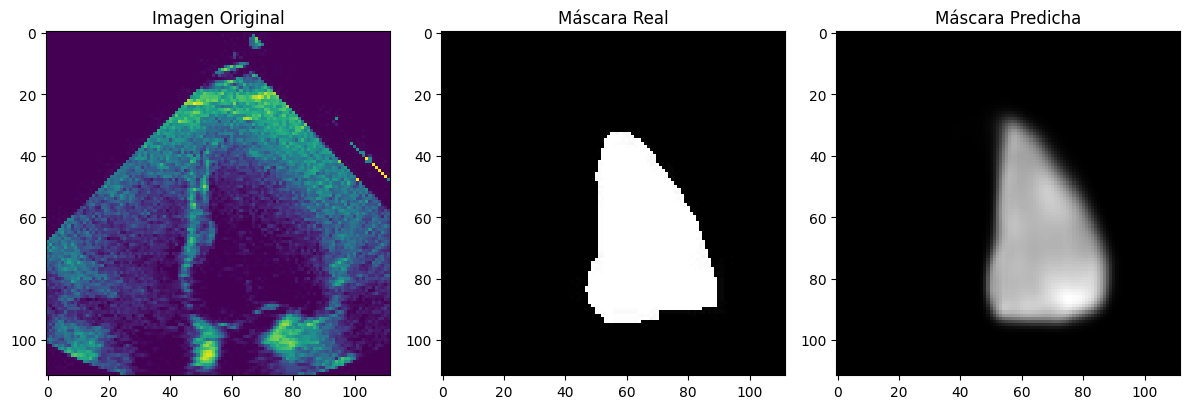

In [81]:
# Visualiza algunas predicciones
import matplotlib.pyplot as plt

num_samples_to_visualize = 5
sample_indices = np.random.choice(len(test_images), num_samples_to_visualize, replace=False)

sample_images = [test_images[i] for i in sample_indices]
sample_masks = [test_masks[i] for i in sample_indices]
sample_predictions = [predictions[i] for i in sample_indices]

# Llama a la función para visualizar las imágenes y máscaras
visualize_segmentation(sample_images, sample_masks, sample_predictions)

In [74]:
# Descargar modelo
model.save('my_model_new.keras')  # Guardar el modelo en formato HDF5